In [11]:
import os
import sys
import numpy   as np
import pandas  as pd
import seaborn as sns

import matplotlib.pyplot         as plt
import mlem.mlem_reconstruct     as mr
import antea.image.fom_functions as fomf

sys.stdout = open(os.devnull, "w") ## Prevents from printing

In [2]:
def read_images(path, tof, n_iter, save_every):
    rec = mr.MLEMReconstructor(libpath=path_to_mlem)
    x, y, z  = (60, 60, 60)
    if tof==0:
        x, y, z  = (180, 180, 180)
        tof = 20
    rec.prefix = f'{path}/rust_images/{x}_{y}_{z}_reco_1mm_no_jitter_tof_{tof}_'
    #print(f'{path}/rust_images/{x}_{y}_{z}_reco_1mm_no_jitter_tof_{tof}_')
    return np.array([rec.read_image(i) for i in range(n_iter)])

path_to_mlem = '/Users/carmenromoluque/tofpet3d/lib/libmlem.so'
im_path      = '/Users/carmenromoluque/nexus_petit_analysis/full-body-phantom-paper/images_reco/photo_range1mm/'

tofs = [20, 60, 80, 100, 110, 120, 130, 150, 140, 160, 170, 180, 200]
tot_it     = 30
save_every = 2

the_images = {tof: read_images(im_path, tof, tot_it, save_every) 
              for tof in tofs}

In [3]:
sig_intensity  =  4
bckg_intensity =  1
radial_pos     = 50.
bckg_radius    =  4.
phi0           = np.pi/6
phi_step       = np.pi/3
n_phi          = 6

hot_radii   = [4., 6.5, 8.5, 11.]
cold_radii  = [14., 18.5]
all_radii   = hot_radii + cold_radii

hot_angles  = [np.pi/3, 2*np.pi/3, 3*np.pi/3, 4*np.pi/3]
cold_angles = [5*np.pi/3, 6*np.pi/3]

x_size = y_size = z_size = 180
x_bins = y_bins = z_bins =  60

radii  = hot_radii  + cold_radii
angles = hot_angles + cold_angles

## CRC

In [7]:
from collections import namedtuple

sph_tof = namedtuple('sph_tof', 'sph, tof')
crc_err = namedtuple('crc_err', 'crcs, errs')

sig_intensity  =  4
bckg_intensity =  1

def get_crcs(images, tof, n_sph):
    calculate_crcs_and_errs = lambda images: fomf.crc_hot3d(images, sig_intensity, bckg_intensity, 
                                                            radii[n_sph], radial_pos, angles[n_sph], 
                                                            bckg_radius, phi0, phi_step, n_phi, 
                                                            x_size, y_size, z_size,
                                                            x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_crcs_and_errs, images[tof]))
    crcs = [r[0]*100 for r in all_images]
    errs = [e[1]*100 for e in all_images]
    print(tof, n_sph)
    return crc_err(crcs=crcs, errs=errs)

crcs = {sph_tof(sph=n_sph, tof=tof):
        get_crcs(the_images, tof, n_sph)
        for tof in tofs
        for n_sph in range(4)}

In [8]:
def get_crcs_cold(images, tof, n_sph):
    calculate_crcs_and_errs = lambda images: fomf.crc_cold3d(images, radii[n_sph], radial_pos, angles[n_sph], 
                                                             bckg_radius, phi0, phi_step, n_phi, 
                                                             x_size, y_size, z_size,
                                                             x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_crcs_and_errs, images[tof]))
    crcs = [r[0]*100 for r in all_images]
    errs = [e[1]*100 for e in all_images]
    print(tof, n_sph)
    return crc_err(crcs=crcs, errs=errs)

crcs_cold = {sph_tof(sph=n_sph, tof=tof):
             get_crcs(the_images, tof, n_sph)
             for tof in tofs
             for n_sph in range(4, 6)}

In [9]:
iterations = np.tile(range(tot_it), len(tofs))
tof_arr    = np.repeat(tofs, tot_it)

crc_arr     = [[] for i in range(4)]
crc_err_arr = [[] for i in range(4)]
for sph in range(4):
    for t in tofs:
        crc_arr    [sph].append(crcs[sph, t][0])
        crc_err_arr[sph].append(crcs[sph, t][1])
crc_arr_0     = np.array(crc_arr    [0]).flatten()
crc_err_arr_0 = np.array(crc_err_arr[0]).flatten()
crc_arr_1     = np.array(crc_arr    [1]).flatten()
crc_err_arr_1 = np.array(crc_err_arr[1]).flatten()
crc_arr_2     = np.array(crc_arr    [2]).flatten()
crc_err_arr_2 = np.array(crc_err_arr[2]).flatten()
crc_arr_3     = np.array(crc_arr    [3]).flatten()
crc_err_arr_3 = np.array(crc_err_arr[3]).flatten()

In [12]:
df_sph0 = pd.DataFrame(np.c_[iterations, tof_arr, crc_arr_0, crc_err_arr_0],
                  columns=["iteration", "tof", "crc", "crc_err"])
df_sph1 = pd.DataFrame(np.c_[iterations, tof_arr, crc_arr_1, crc_err_arr_1],
                  columns=["iteration", "tof", "crc", "crc_err"])
df_sph2 = pd.DataFrame(np.c_[iterations, tof_arr, crc_arr_2, crc_err_arr_2],
                  columns=["iteration", "tof", "crc", "crc_err"])
df_sph3 = pd.DataFrame(np.c_[iterations, tof_arr, crc_arr_3, crc_err_arr_3],
                  columns=["iteration", "tof", "crc", "crc_err"])

cols = ['iteration', 'tof']
df_sph0[cols] = df_sph0[cols].applymap(np.int32)
df_sph1[cols] = df_sph1[cols].applymap(np.int32)
df_sph2[cols] = df_sph2[cols].applymap(np.int32)
df_sph3[cols] = df_sph3[cols].applymap(np.int32)

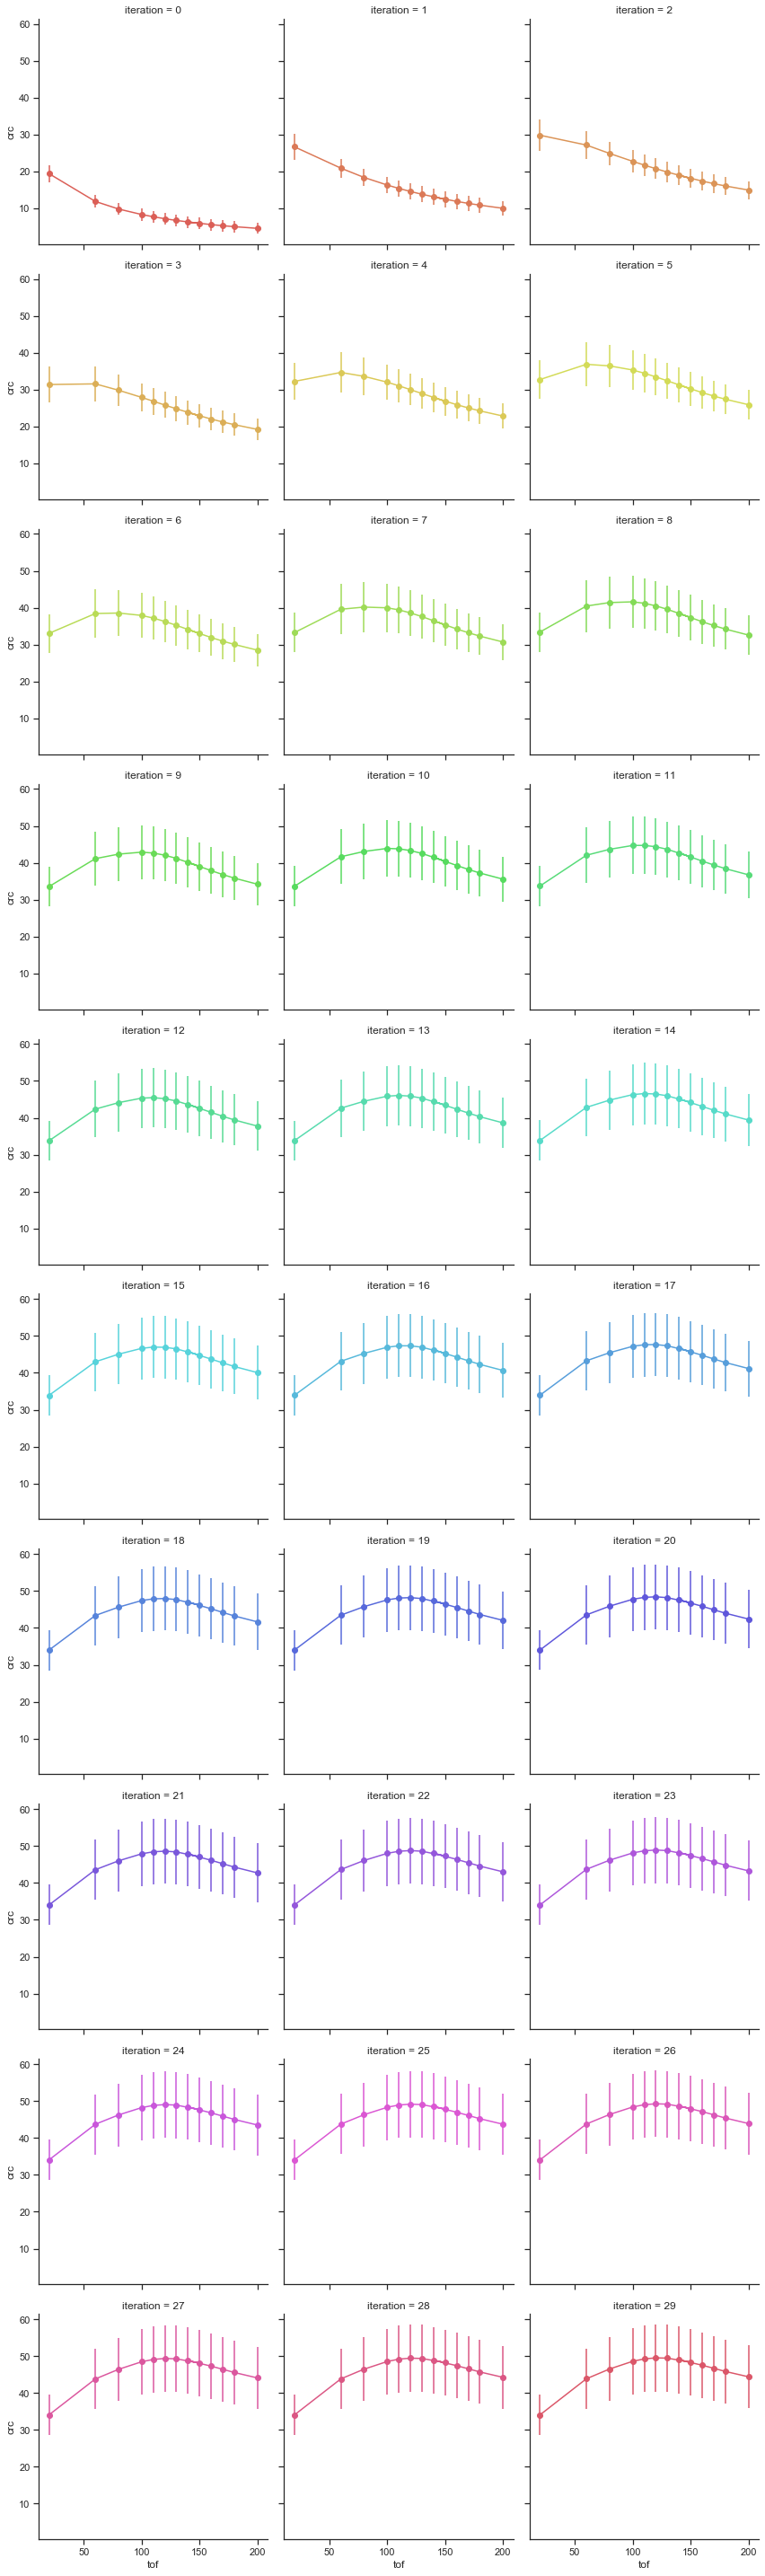

In [13]:
sns.set_theme(style="ticks")
grid = sns.FacetGrid(df_sph0, col="iteration", hue="iteration", palette="hls", col_wrap=3, height=4)
grid.map(plt.errorbar, "tof", "crc", "crc_err", marker="o")
grid.fig.tight_layout(w_pad=1);

print('Sphere 0')

In [15]:
from typing import Sequence
from typing import Dict

def plot_crc_sphs(crcs:    Dict[sph_tof, crc_err], 
                  spheres: Sequence[int], 
                  tof:     int,
                  num_it:  int):
    images_wanted = int(num_it/save_every)
    for n_sphere in spheres:
        sphere = crcs[sph_tof(sph=n_sphere, tof=tof)]
        plt.errorbar(x = list(range(0, num_it, save_every)),
                     y =    sphere.crcs[:images_wanted], 
                     yerr = sphere.errs[:images_wanted], 
                     xerr = None,
                     marker = 's', 
                     capsize = 3,
                     label =f'sph{n_sphere}, TOF={tof}ps')

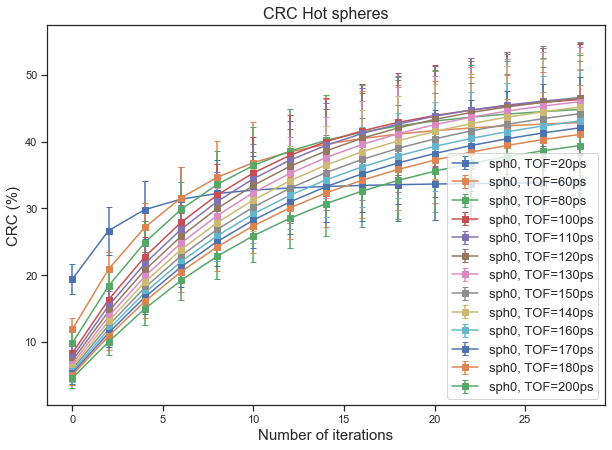

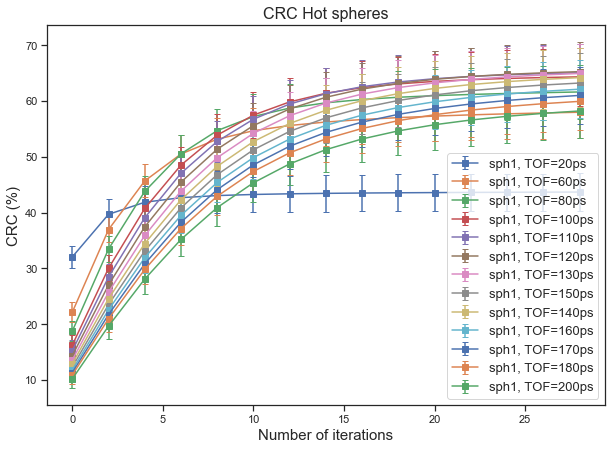

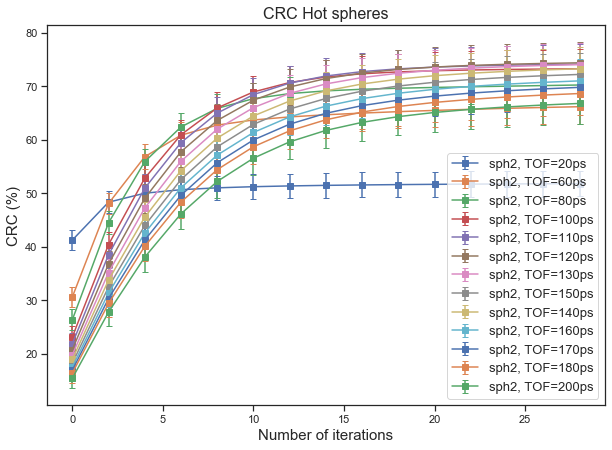

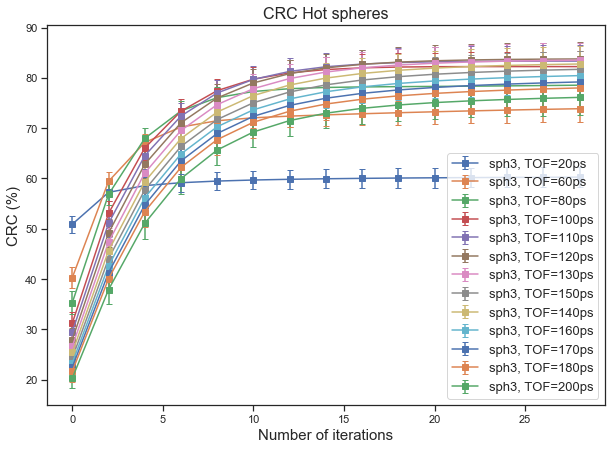

In [16]:
for sph in range(4):
    plt.figure(figsize=(10,7))
    for tof in tofs:
        plot_crc_sphs(crcs, range(sph, sph+1), tof=tof, num_it=30)
    plt.title(f'CRC Hot spheres', fontsize=16)
    plt.xlabel('Number of iterations', fontsize=15)
    plt.ylabel('CRC (%)', fontsize=15)
    plt.legend(loc=4, fontsize=13, ncol=1)
    plt.show()